**Set data path**

In [1]:
path = "measurements/Participant_test1/"

## Start postprocessing

- `isoforce_iso` contains the data recorded with the Isoforce
- `isoforce_py_raw` contains the Isoforce data recorded with the Python script
- `sciospec_EIT_raw` contains the EIT data recorded with the EIT device

In [2]:
import os
from glob import glob

import matplotlib.pyplot as plt
import numpy as np

from src.postprocessing import (
    IsoforceIso,
    ProcessingDir,
    process_sciospec_eit,
    renderDF,
)

In [3]:
part_path = ProcessingDir(path)

Fund participant data:

Head directory: self.path='measurements/Participant_test1/'
Raw Isoforce data measured by Isoforce:
	self.isoforce_iso='measurements/Participant_test1/Test_1_JO_raw_data_10012025154959.txt'
Raw Isoforce data measured by Python:
	self.isoforce_py_raw='measurements/Participant_test1/Isokinetic_raw/'
Raw sciospec EIT data:
	self.sciospec_EIT_raw='measurements/Participant_test1/EIT_raw/'
Raw sciospec EIT samples:
	self.EIT_samples_raw='measurements/Participant_test1/EIT_raw/20250113 09.24.18/setup/'
Preprocessed sciospec EIT samples:
	self.s_path_eit='measurements/Participant_test1/EIT_processed/'


In [4]:
DF = renderDF(part_path.isoforce_iso)

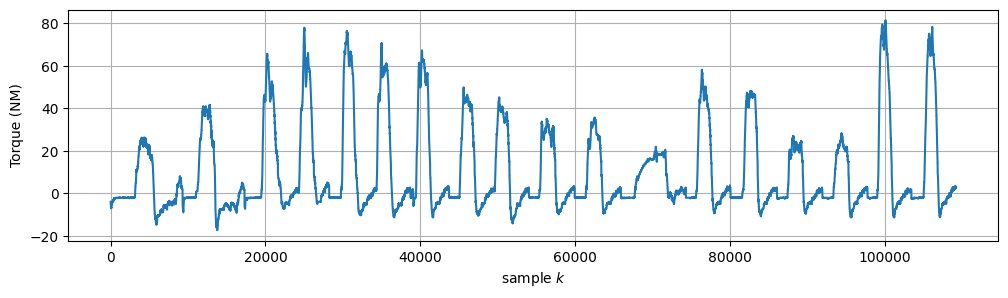

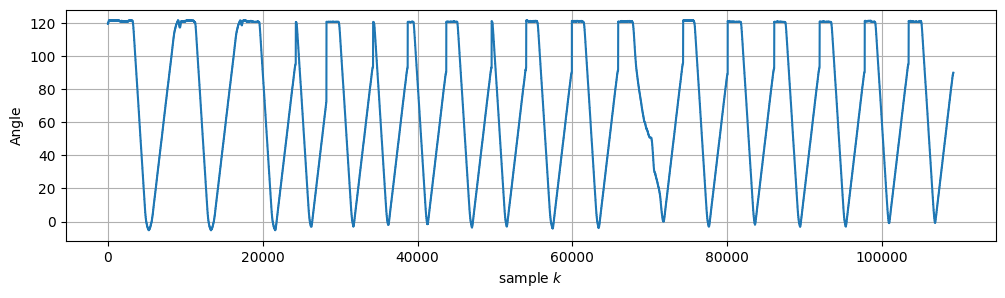

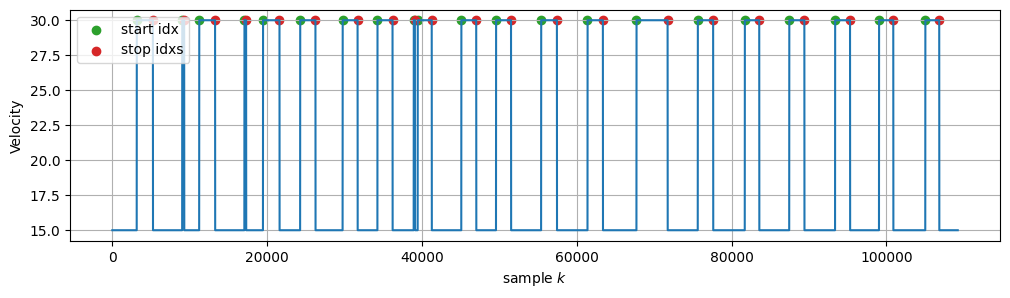

In [5]:
isoforce_iso = IsoforceIso(DF)
isoforce_iso.plot_torque()
isoforce_iso.plot_angle()
isoforce_iso.plot_velocity()

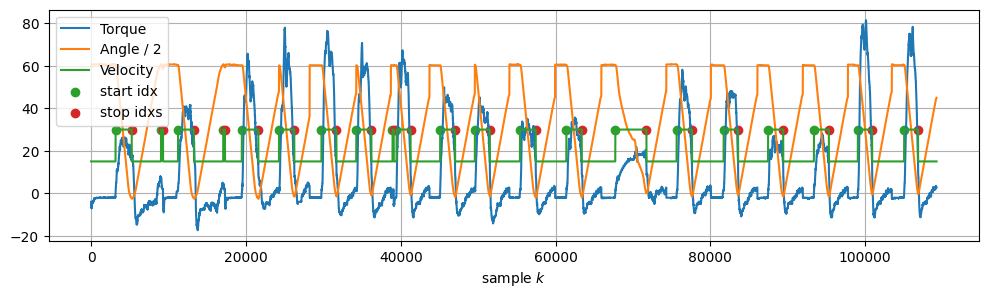

In [6]:
isoforce_iso.plot_data()

20.0
4.0
31.0
3.0
40.0
45.0
51.0
45.0
1.0
48.0
36.0
32.0
26.0
25.0
14.0
37.0
38.0
20.0
19.0
56.0
52.0


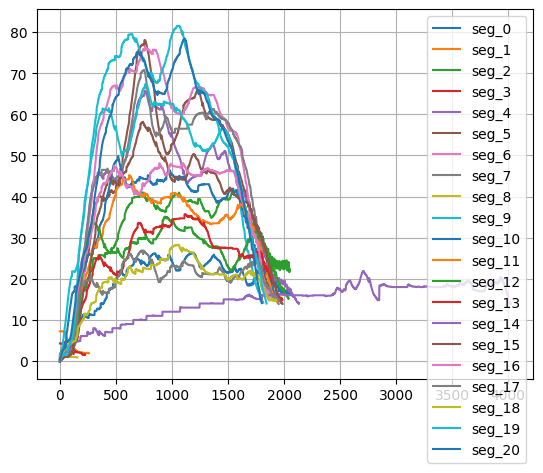

In [7]:
for key in isoforce_iso.torque_segments.keys():
    plt.plot(isoforce_iso.torque_segments[key], label=key)
    print(np.round(np.mean(isoforce_iso.torque_segments[key])))
plt.legend()
plt.grid()
plt.show()

**EIT Sciospec raw**

In [8]:
part_path.print_info()

Fund participant data:

Head directory: self.path='measurements/Participant_test1/'
Raw Isoforce data measured by Isoforce:
	self.isoforce_iso='measurements/Participant_test1/Test_1_JO_raw_data_10012025154959.txt'
Raw Isoforce data measured by Python:
	self.isoforce_py_raw='measurements/Participant_test1/Isokinetic_raw/'
Raw sciospec EIT data:
	self.sciospec_EIT_raw='measurements/Participant_test1/EIT_raw/'
Raw sciospec EIT samples:
	self.EIT_samples_raw='measurements/Participant_test1/EIT_raw/20250113 09.24.18/setup/'
Preprocessed sciospec EIT samples:
	self.s_path_eit='measurements/Participant_test1/EIT_processed/'


In [9]:
try:
    os.mkdir(part_path.s_path_eit)
    process_sciospec_eit(part_path)
except BaseException:
    print("Directory already exists.")

Directory already exists.


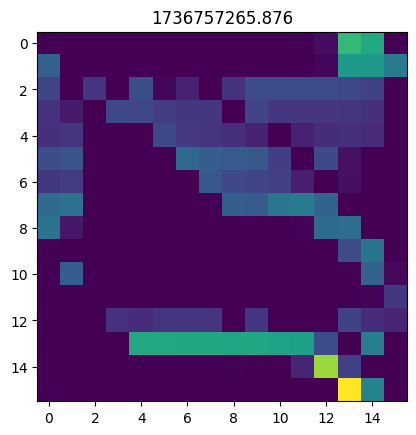

In [10]:
tmp = np.load(part_path.s_path_eit + "setup_00002.npz", allow_pickle=True)
tmp_2 = np.load(part_path.s_path_eit + "setup_00003.npz", allow_pickle=True)
tmp.files

plt.title(tmp["timestamp"])
plt.imshow(np.abs(tmp["eit"]))
plt.show()

**Isoforce Python raw**

- Ch_1, P = Position = red (C3) {Factor = 54, Offset = 12}
- Ch_2, T = Torque = blue (C0) {Factor = 150, Offset = 24}
- Ch_3, S = Speed = yellow (C8) {Factor = 108, Offset = -4}

In [11]:
part_path.isoforce_py_raw

'measurements/Participant_test1/Isokinetic_raw/'

In [12]:
from src.postprocessing import IsoforcePy

In [13]:
isoforce_py = IsoforcePy(part_path.isoforce_py_raw, LP_filter=True, over_UTC=False)

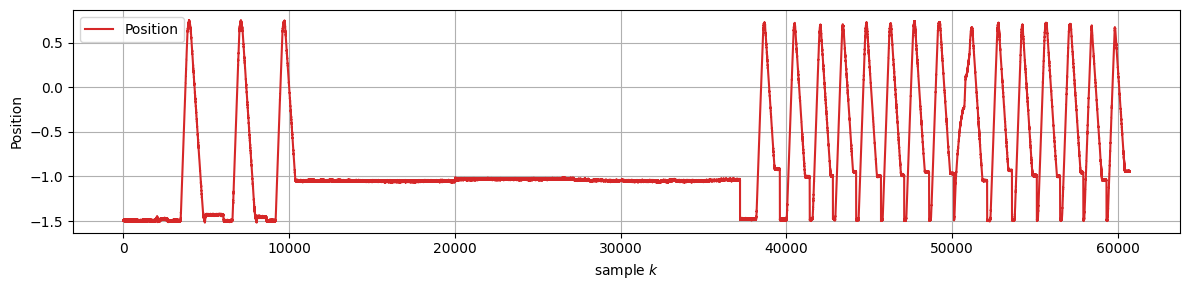

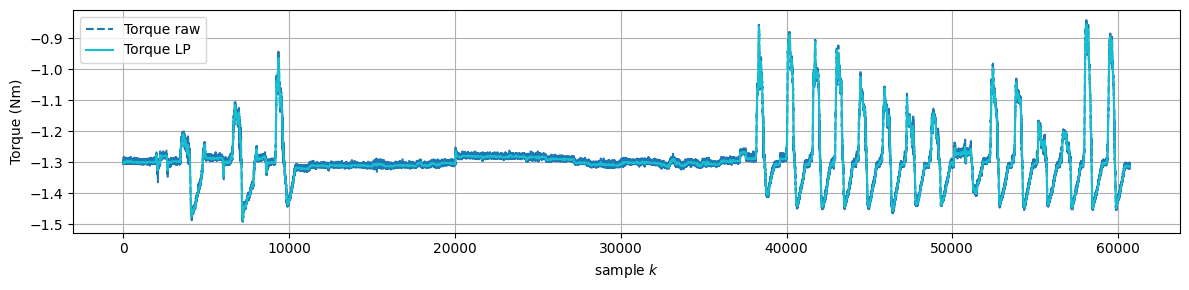

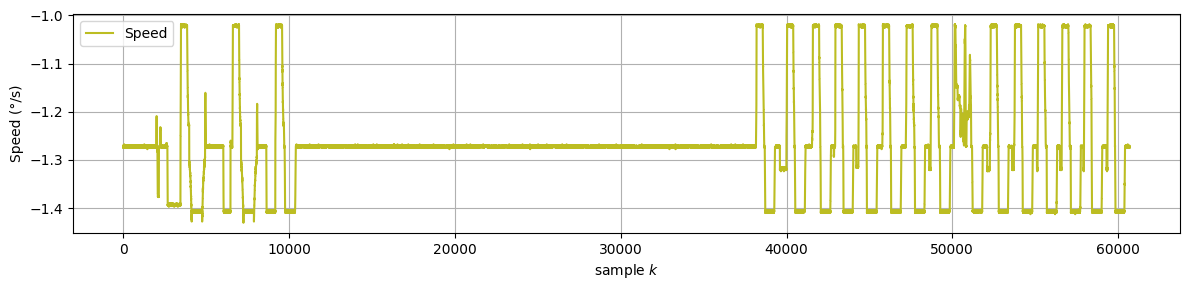

In [14]:
isoforce_py.plot_angle()
isoforce_py.plot_torque()
isoforce_py.plot_velocity()

- Ch_1, P = Position = red (C3) {Factor = 54, Offset = 12}
- Ch_2, T = Torque = blue (C0) {Factor = 150, Offset = 24}
- Ch_3, S = Speed = yellow (C8) {Factor = 108, Offset = -4}

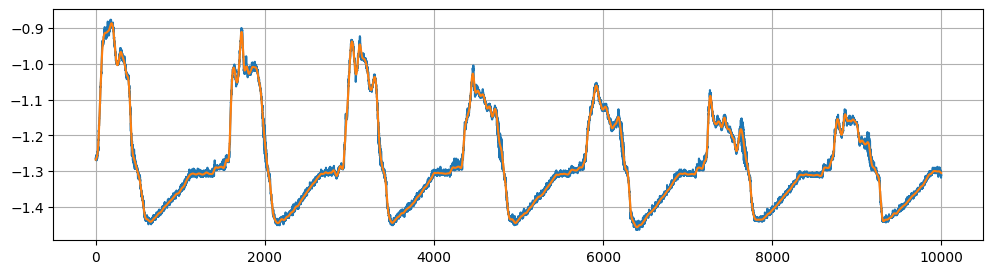

In [16]:
plt.figure(figsize=(12, 3))
plt.plot((isoforce_py.all_torque[40_000:50_000]))
plt.plot((isoforce_py.all_torque_LP[40_000:50_000]))
plt.grid()

Sliding window approach